In [1]:
from __future__ import print_function

import itertools as it

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

import pickle

import numpy as np

import pandas as pd

% matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set()

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

import joblib

from libs.container import Container
from libs.display import d
from libs.experiment import KFoldExperiment, WithAnotherExperiment, roc, metrics

In [2]:
cpu = joblib.cpu_count()

In [3]:
sample = pd.read_pickle("data/scaled/sample.pkl.bz2")
sample["tile"] = sample["id"].apply(lambda i: "b" + str(i)[1:4])

no_features = ["id", "vs_catalog", "vs_type", "ra_k", "dec_k", "tile", "cls"] 
X_columns = [c for c in sample.columns if c not in no_features]

grouped = sample.groupby("tile")
data = Container({k: grouped.get_group(k).copy() for k in grouped.groups.keys()})

del grouped, sample

In [4]:
RF_PARAMS = {
    'max_features': .5, 'min_samples_split': 10, 'n_jobs': cpu, 
    'criterion': 'entropy', 'n_estimators': 500}

sX_columns = [ 'MaxSlope',
 'Mean',
 'PercentDifferenceFluxPercentile',
 'c89_m2',
 'cnt']

In [17]:
POSITIONS = {
    'b206': (13, 8),
    'b214': (13, 0),
    'b216': (12, 12),
    'b220': (12, 8),
    'b228': (12, 0),
    'b234': (11, 8),
    'b247': (10, 9),
    'b248': (10, 8),
    'b261': ( 9, 9),
    'b262': ( 9, 8),
    'b263': ( 9, 7),
    'b264': ( 9, 6),
    'b277': ( 8, 7),
    'b278': ( 8, 6),
    'b356': (2, 12),
    'b360': (2, 8),
    'b396': ( 0, 0),
}

for k in data.keys():
    assert k in POSITIONS, k

In [18]:

order = sorted(POSITIONS, key=POSITIONS.get, reverse=True)

combs = {}
for ta, tb in it.combinations(order, 2):
    k = "{}_{}".format(ta, tb)
    df = pd.concat([data[ta], data[tb]])
    
    cls = {name: idx for idx, name in enumerate(df.tile.unique())}
    df["cls"] = df.tile.apply(cls.get)
    
    combs[k] = df

data = Container(combs)
del combs

cls = {0: 0, 1: 1}

In [19]:
%%time
results = {}
total = len(data.keys())
for idx, c in enumerate(data.keys()):
    print("[{}/{}] {} vs {}".format(idx, total, *c.split("_")))
    rf = KFoldExperiment(
        clf=RandomForestClassifier(**RF_PARAMS), clsnum=cls, verbose=False,
        data=data, pcls=1, ncls=0, X_columns=sX_columns, y_column="cls")
    rf = rf(c, nfolds=10)
    results[c] = rf

[0/136] b247 vs b396
[1/136] b263 vs b277
[2/136] b263 vs b278
[3/136] b247 vs b261
[4/136] b248 vs b360
[5/136] b264 vs b356
[6/136] b216 vs b396
[7/136] b234 vs b277
[8/136] b234 vs b278
[9/136] b277 vs b278
[10/136] b220 vs b277
[11/136] b228 vs b356
[12/136] b247 vs b248
[13/136] b220 vs b278
[14/136] b214 vs b396
[15/136] b206 vs b234
[16/136] b216 vs b264
[17/136] b263 vs b360
[18/136] b264 vs b360
[19/136] b248 vs b277
[20/136] b216 vs b263
[21/136] b216 vs b262
[22/136] b216 vs b261
[23/136] b234 vs b360
[24/136] b248 vs b278
[25/136] b220 vs b264
[26/136] b228 vs b360
[27/136] b220 vs b262
[28/136] b220 vs b263
[29/136] b220 vs b261
[30/136] b214 vs b228
[31/136] b206 vs b220
[32/136] b206 vs b228
[33/136] b262 vs b396
[34/136] b277 vs b396
[35/136] b263 vs b356
[36/136] b248 vs b262
[37/136] b248 vs b263
[38/136] b248 vs b264
[39/136] b214 vs b264
[40/136] b264 vs b277
[41/136] b216 vs b278
[42/136] b234 vs b356
[43/136] b216 vs b277
[44/136] b264 vs b278
[45/136] b214 vs b23

In [20]:
rows = []
for k, r in sorted(results.items()):
    ta, tb = k.split("_")
    row = {
        "Tile A": ta, 
        "Tile B": tb,
        "Prec.": metrics.precision_score(r.y_test, r.predictions),
        "Recall": metrics.recall_score(r.y_test, r.predictions),
        "AUC": r.roc_auc}
    rows.append(row)

In [21]:
df = pd.DataFrame(rows)[["Tile A", "Tile B", "Prec.", "Recall", "AUC"]]
df.head()

,Tile A,Tile B,Prec.,Recall,AUC
0,b206,b214,0.782700,0.74200,0.864114
1,b206,b216,0.977107,0.93900,0.995283
2,b206,b220,0.980119,0.98600,0.999144
3,b206,b228,0.841686,0.73974,0.890787
4,b206,b234,0.971579,0.92300,0.989327


In [22]:
df.describe()

,Prec.,Recall,AUC
count,136.000000,136.000000,136.000000
mean,0.902836,0.901639,0.952934
std,0.087827,0.089338,0.072204
min,0.537328,0.506507,0.558122
25%,0.878854,0.878172,0.953074
50%,0.910294,0.920000,0.971168
75%,0.976958,0.963861,0.996122
max,0.997963,1.000000,0.999983


In [23]:
df.to_pickle("data/results/all_vs_all.pkl")

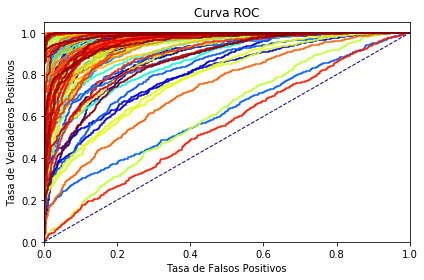

In [24]:
from matplotlib import cm

def roc(results, cmap="jet", ax=None, save_to=None):
    if ax == None:
        ax = plt.gca()
    
    cmap = cm.get_cmap(cmap)
    colors = iter(cmap(np.linspace(0, 1, len(results))))

    if isinstance(results, dict):
        for cname, res  in results.items():
            color = next(colors)
            label = '%s (area = %0.2f)' % (cname, res["roc_auc"])
            ax.plot(res["fpr"], res["tpr"], color=color, label=label)
    else:
        for res in results:
            cname = "Vs.{}".format(res.test_name)
            color = next(colors)
            label = '%s (area = %0.2f)' % (cname, res["roc_auc"])
            ax.plot(res["fpr"], res["tpr"], color=color, label=label)

    ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Tasa de Falsos Positivos')
    ax.set_ylabel('Tasa de Verdaderos Positivos')
    ax.set_title('Curva ROC')
#     ax.legend(loc="lower right")
    
    plt.tight_layout()
    
    return ax

roc(results)